# Introduction to Math for Natural Language Processing

If you can't explain it simply, you don't understand it well enough.”
— Albert Einstein (1947), supposedly derived from Rutherford “barmaid” comment



## 1.1. Who is this tutorial for?
* People wanting to understand basic math behind every-day Natural Language Processing (NLP) concepts. People coming from fields without much math and want a basic introduction with clear steps on how to learn more of each topic. References for more advanced introductions will be referenced throughout this tutorial. 

* Knowledge in Python is not necessary
* Very basic familiarity with NLP or machine learning is recommended (validation, train-test split, supervised learning). 

## 1.2. Overview
* We will explain what word embeddings are.
* Train a neural network on these word embeddings to classify semantic categories of Wikipedia sentences. 
* Then we will reduce the dimensionality of the word embeddings and neural network hidden layers with Principal Component Analysis to visualize them in 2D. 
* The math behind these techniques will be explained for beginners.  



# 2. Vector semantics

## 2.1. Word embeddings

Word embeddings are a way of turning the meaning of words into a vector (an array of numbers) that can be used for mathematical operations. For instance, by using word vectors, we can do the following operation: Paris - France + Italy = Rome. We first need to quantify the meaning of words. In order to do this, take into account this example from Jurafsky and Martin (2017):

```
A bottle of tesguino is on the table. Everybody likes tesguino.
Tesguino makes you drunk.
We make tesguino out of corn.
```

This example shows that the meaning of a word is related to the distribution of words that tend to accompany it, which is known as the **distributional hypothesis**. To do this systematically, you can count how many times every word appears near a word of interest. We do this through a **word-word matrix**, where each cell represents the number of times (in some corpus) the column word occurs in a ±N word window around the row word. For example, here are 7-word windows surrounding four sample words from the Brown corpus (just one example of each word):

![title](figures/vector_semantics_window.png)

So let's build the word-word matrix. We first build an empty matrix and then fill it with the co-ocurrences of words:

In [1]:
import numpy as np
import pandas as pd
import math

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
rows = ['apricot', 'pineapple', 'digital', 'information']
columns = ['umbrella', 'computer', 'data', 'pinch', 'result', 'sugar', '...']

counts = np.zeros((len(rows), len(columns))) #these are the amount of counts we'll have to fill in
word_word = pd.DataFrame(counts, columns = columns, index=rows)
print(word_word)



             umbrella  computer  data  pinch  result  sugar  ...
apricot           0.0       0.0   0.0    0.0     0.0    0.0  0.0
pineapple         0.0       0.0   0.0    0.0     0.0    0.0  0.0
digital           0.0       0.0   0.0    0.0     0.0    0.0  0.0
information       0.0       0.0   0.0    0.0     0.0    0.0  0.0


So counting how many times row words (targets) appear with the column words (vocabulary), we fill in the above matrix by counting the amount of co-occurences between both types of words within a window. For instance, the meaning of _information_ approximately equals [0,1,6,0,4,0,...] because it has 0 co-ocurrences with _umbrella_, 1 with _computer_, 6 with _data_, 0 with _pinch_, 0 with _sugar_, and so on, for all words in the corpus (e.g., 50.000 words). Thus its meaning is quantified in order to do some math with it.

In [3]:
apricot_counts =   [0,0,0,1,0,1,'...']
pineapple_counts = [0,0,0,1,0,1,'...']
digital_counts = [0,2,1,0,1,0,'...']
information_counts = [0,1,6,0,4,0,'...']

word_word.iloc[0,:] = apricot_counts
word_word.iloc[1,:] = pineapple_counts
word_word.iloc[2,:] = digital_counts
word_word.iloc[3,:] = information_counts
word_word

,umbrella,computer,data,pinch,result,sugar,...
apricot,0.0,0.0,0.0,1.0,0.0,1.0,...
pineapple,0.0,0.0,0.0,1.0,0.0,1.0,...
digital,0.0,2.0,1.0,0.0,1.0,0.0,...
information,0.0,1.0,6.0,0.0,4.0,0.0,...



### 2.2. Visualization of two dimensions

Each row word has N dimensions. Here we know 6 of its dimensions, but we could see how it co-occurrs with all words (e.g., 50.000). 

Let's visualize the meaning using just two dimensions (since 50.000 dimensions cannot be visualized):


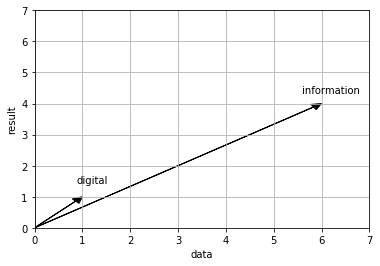

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import axes

def plot_vectors(digital_data_coocurrences = 1):
    fig, ax = plt.subplots()
    ax.set(xlim=[0,7],ylim=[0,7],autoscale_on=True,clip_on=True)
    # ax.set(frame_on=False,xticks=[],yticks=[])
    ax.arrow(0, 0, digital_data_coocurrences,1, shape='full', length_includes_head=True, head_width=0.2, head_length=0.2, fc='k', ec='k')

    ax.arrow(0, 0, 6,4, shape='full', length_includes_head=True, head_width=0.2, head_length=0.2, fc='k', ec='k')
    ax.text(digital_data_coocurrences+0.2,1.7,'digital',
            verticalalignment='top',
            horizontalalignment='center')
    ax.text(6.2,4.6,'information',
            verticalalignment='top',
            horizontalalignment='center')
    ax.set_xlabel('data')
    ax.set_ylabel('result')
    plt.grid()
    plt.show()
    
plot_vectors()

A spatial visualization of word vectors for digital and information, showing just two of the dimensions, corresponding to the words data and result. A more accurate representation would include the whole vocabulary (e.g., 50k dimensions) and the direction and length of the vector would change.

Below you can adjust how many co-ocurences digital and data have.

In [5]:
%matplotlib inline
from ipywidgets import interact, fixed
from ipywidgets import interactive

interactive_plot = interactive(plot_vectors, digital_data_coocurrences=(0,7)) 
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

### What is a vector?

Vectors have a magnitude (length in geometric representations) and a direction.

![title](figures/vectors.png)

Image from https://www.grc.nasa.gov/WWW/K-12/airplane/vectcomp.html







### 2.3. Measure distance or similarity

If one wishes to know how similar these two words are, then one can simple calculate the distance between them. There are many ways of calculating the distance. Let's review two:


#### 2.3.1. Euclidean distance



The Euclidean distance is a distance measure between two points or vectors in a two- or multidimensional (Euclidean) space. Geometrically, it is a straight line from point to point. The distance is calculated by taking the square root of the sum of the squared pair-wise distances of every dimension:


$$ \sqrt{\sum_{i=1}^n (x_i-y_i)^2}  $$

which in our toy example is:
    
$$ \sqrt{\ (1-6)^2 + (1-4)^2} = 5.83 $$

And the vector is give by $$||[1,1]-[6,4])||=||[-5,-3]|| = [5,3]$$


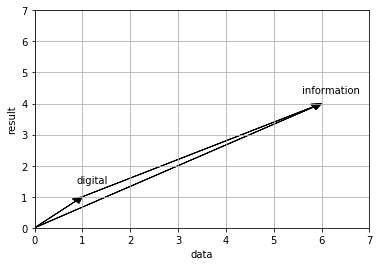

In [6]:
def plot_distance(digital_data_coocurrences = 1):
    fig, ax = plt.subplots()
    ax.set(xlim=[0,7],ylim=[0,7],autoscale_on=True,clip_on=True)
    # ax.set(frame_on=False,xticks=[],yticks=[])
    ax.arrow(0, 0, digital_data_coocurrences,1, shape='full', length_includes_head=True, head_width=0.2, head_length=0.2, fc='k', ec='k')

    ax.arrow(0, 0, 6,4, shape='full', length_includes_head=True, head_width=0.2, head_length=0.2, fc='k', ec='k')
    ax.arrow(1, 1, 5,3, shape='full', length_includes_head=True, head_width=0.2, head_length=0.2, color='black')
    ax.text(digital_data_coocurrences+0.2,1.7,'digital',
            verticalalignment='top',
            horizontalalignment='center')
    ax.text(6.2,4.6,'information',
            verticalalignment='top',
            horizontalalignment='center')
    ax.set_xlabel('data')
    ax.set_ylabel('result')
    plt.grid()
    plt.show()
    
plot_distance()

#### 2.3.2. Cosine distance

The issue with the Euclidean metric is that the distance depends on the amount of times a given word appears in the corpus in general (it's frequency). If the word _man_ appears 1.000 times, and the word _gentleman_ appears 10 times in the corpus, then these may be far appart even though they are similar in meaning.

Therefore, one can compute the cosine similarity between two vectors. Cosine similarity measures the orientation of two n-dimensional sample vectors irrespective to their length or magnitude (the length of the vectors does not matter). It is calculated by the dot product of two numeric vectors, and it is normalized by the product of the vector lengths, so that output values close to 1 indicate high similarity (angle close to 0).

**Normalized vector**: same direction but length = 1. 
                                                                                                                              
$$cos(\pmb x, \pmb y) = \frac {\pmb x \cdot \pmb y}{||\pmb x|| \cdot ||\pmb y||}$$
                                                                                                                                                                                                                                                     
where $\pmb x$ and $\pmb y$ are the word vectors and ${||\pmb v||}$ is the length of $\pmb v$.
                                                                                                                              
$${||\pmb v||} = \sqrt{\ (v_x)^2 + (v_y)^2} $$
                                                                                                                              
Therefore, the $$cos(digital, information) = \frac {[1,1] \cdot [6,4]}{||[1,1]|| \cdot ||[6,4]||}
= \frac {[6,4]}{\sqrt{2}\cdot \sqrt{50}}
= \frac {1}{10.2} \cdot [6,4] = 0.58 + 0.39 = 0.98$$

And this metric can be visualized as follows:
 ![title](figures/cosine.png)
 
 Image obtained from http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/


We can also compute this automatically in Python with:    

In [7]:
from scipy.spatial.distance import *
vector1 = [1,1]
vector2 = [6,4]
print('Euclidean distance:',np.round(euclidean(vector1, vector2), 2))
print('Cosine similarity: ',np.round(1-cosine(vector1, vector2), 2))

Euclidean distance: 5.83
Cosine similarity:  0.98


In [8]:
from scipy.spatial.distance import *
vector1 = [1,1]
vector2 = [6,4]

print('Euclidean distance:',np.round(euclidean(vector1, vector2), 2))
print('Cosine similarity: ',np.round(1-cosine(vector1, vector2), 2))

Euclidean distance: 5.83
Cosine similarity:  0.98


If more contexts (e.g., sentences, documents) are added to the corpus and we find that the word digital co-ocurrs more times with the word data, then this representation would change on that dimension (and stay constant on other dimensions). Here you can move the widget to increase the amounts of co-occurrences and see how the word vector changes.    

Change the first vector to another value to see how these metrics change. If you assign 6 to x dimension in vector1, then you can see that the distance between the vectors is 3.0, which you can also manually count in the interactive geometric representation above repeated below. The similarity changes when digital is [6,1,]. You can count an Euclidean distance of 3.

In [9]:
vector1 = [6,1]
vector2 = [6,4]
print('Euclidean distance:',np.round(euclidean(vector1, vector2), 2))
print('Cosine similarity: ',np.round(1-cosine(vector1, vector2), 2))

Euclidean distance: 3.0
Cosine similarity:  0.91


In [11]:
%matplotlib inline
from ipywidgets import interact, fixed
from ipywidgets import interactive

interactive_plot = interactive(plot_vectors, digital_data_coocurrences=(0,7)) 
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [12]:
vector1_x = 6
vector1 = [vector1_x,1]
vector2 = [6,4]

print('Euclidean distance:',np.round(euclidean(vector1, vector2), 2))
print('Cosine similarity: ',np.round(1-cosine(vector1, vector2), 2))

Euclidean distance: 3.0
Cosine similarity:  0.91


### 2.4. Pre-trained word embeddings
There are several pre-trained word embeddings you can download that should capture word meaning quite well since they trained on billions of words. Google word2vec and Stanford Glove embeddings are two of the most popular ones. Glove uses the **count-based approach** we saw using the word-word matrix, and it then performs dimensionality reduction (see section 3 of this tutorial) to reduce the dimensions. word2vec uses a **prediction model** to predict the upcoming word in a sentence given the previous words using a neural network. For further understanding, see these tutorials:

- https://www.youtube.com/watch?v=ASn7ExxLZws
- http://blog.aylien.com/overview-word-embeddings-history-word2vec-cbow-glove/


Let's load Glove 50 dimensional embeddings from http://nlp.stanford.edu/data/glove.6B.zip contained in the Stanford Glove website: https://nlp.stanford.edu/projects/glove/.

You can save the 50D embeddings in the directory where this .ipynb is saved. 



In [13]:
import pandas as pd
import csv

path = './glove.6B.50d.txt' #This should be downloaded into your directory from link in README.
words = pd.read_table(path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

Now we can get a 50 dimensional vector 400k words. Let's load and print the first few:

In [14]:
words.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
",",0.013441,0.236820,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.17684,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.18048,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.17792,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044


Let's see the vector for _Paris_

In [15]:
paris = words.loc['paris']
print(paris)

1     0.769890
2     1.181000
3    -1.129900
4    -0.747250
5    -0.596900
6    -1.051800
7    -0.465520
8     0.270090
9    -0.992430
10   -0.048640
11    0.286420
12   -0.752610
13   -1.056600
14   -0.192050
15    0.572000
16   -0.243910
17   -0.360540
18   -0.708760
19   -0.919510
20   -0.270240
21    1.513100
22    1.031300
23   -0.557130
24    0.529520
25   -0.714940
26   -1.094900
27   -0.605650
28    0.313290
29   -0.444880
30    0.559150
31    2.142900
32    0.433890
33   -0.552900
34   -0.242610
35   -0.436790
36   -0.960140
37    0.258280
38    0.793850
39    0.371320
40    0.496230
41    0.843590
42   -0.258750
43    1.561600
44   -1.119900
45    0.091676
46    0.076675
47   -0.450840
48   -0.861040
49    0.975990
50   -0.356150
Name: paris, dtype: float64


Let's get the word embeddings for _France_, _Italy_, _Paris_ and _Rome_ and print the 50D vector for France. 

In [16]:
def vec(w):
  return np.array(words.loc[w].values)

france = vec('france')
italy = vec('italy')
paris = vec('paris')
rome = vec('rome')
print(france)



[ 6.6571e-01  2.9845e-01 -1.0467e+00 -6.6932e-01 -7.8082e-01 -1.3007e-04
 -1.7931e-01  3.7110e-01 -1.8622e-01 -4.0535e-01  9.8644e-01 -6.0545e-01
 -9.4571e-01 -6.9207e-01  5.6681e-01 -3.8610e-01  2.7634e-02 -1.2464e+00
 -7.3561e-01 -5.2222e-01 -6.1766e-02  1.6771e-01 -3.7462e-01  4.2250e-01
 -6.3095e-01 -1.6360e+00 -2.5094e-01  4.4950e-02 -3.9758e-01  9.8099e-01
  2.6293e+00  8.3480e-01 -7.7338e-01  3.9402e-01 -5.7976e-01 -1.0290e+00
 -2.6709e-01  9.8714e-01 -5.1029e-01 -4.2477e-01  1.3956e+00 -2.9347e-02
  2.2295e+00 -1.7079e+00  2.5562e-02  6.9060e-01 -5.7900e-01 -1.7824e-01
  4.2916e-01 -5.3940e-01]


In [17]:
france = words.loc['france']
italy = words.loc['italy']
rome = words.loc['rome']

If these vectors are actually capture the meaning of these words, then this should work:

Paris - France + Italy = Rome 

This means the resulting vector should be closest to the vector for Rome more than any other vector. Let's see:

In [18]:
def find_closest_word(v, return_n=10):
    diff = words - v
    delta = np.sum(diff * diff, axis=1)
    most_similar = np.argsort(delta)[:return_n]
    print('Most similar words to input vector:')
    for i,j in enumerate(most_similar):
        print(i, words.iloc[j].name)

print(find_closest_word(paris-france+italy))


Most similar words to input vector:
0 rome
1 turin
2 italy
3 venice
4 naples
5 aires
6 buenos
7 milan
8 paris
9 lisbon
None


worked! The most similar word is _rome_ followed by other Italian cities. 

In [19]:
paris-france+italy

1     1.874580
2     0.104970
3    -1.036220
4     0.251070
5     0.224311
6    -1.138022
7    -0.382536
8    -0.246260
9    -1.660360
10    0.265395
11    0.018230
12   -0.984960
13   -0.828130
14    0.199240
15    1.263990
16   -0.585090
17   -0.652324
18    0.362950
19   -0.760950
20    0.586980
21    1.059536
22    0.431360
23   -0.984250
24    1.053460
25   -0.074154
26   -0.785300
27    0.241330
28    0.139910
29   -1.066000
30   -0.165790
31    2.122200
32    0.478840
33   -0.083960
34   -0.319620
35   -0.518390
36   -0.090820
37    0.238200
38    1.255310
39    0.279910
40    0.273060
41   -0.172770
42   -0.042973
43    0.605000
44   -0.632700
45   -0.143116
46    0.580875
47   -0.051840
48   -1.036050
49    0.991710
50   -0.653500
dtype: float64

Using this method the tools explained here with a different set of embeddings, the Google word2vec embeddings, you obtain these interesting results that demonstrate that these vectors are capturing meaning:
![title](figures/vector_subtractions.png)

This doesn't work for all words and doesn't capture different aspects of meaning (e.g., polisemy, irony, figurativeness), but it usually allows models to achieve higher performance. Using 300D Glove embeddings or word2vec embeddings, you may get better results. But for instance, with these 50D Glove embeddings, you don't obtain the first result: 

In [20]:
print(find_closest_word(vec('water') - vec('wet') + vec('fire')))

Most similar words to input vector:
0 fire
1 gas
2 carrying
3 from
4 to
5 massive
6 bomb
7 carried
8 attack
9 carry
None


You can also average the words in a sentence to obtain a representation of a sentence: 

In [21]:
sentence1 = np.mean([vec('i'), vec('went'), vec('to'), vec('paris')], axis=0)
sentence2 = np.mean([vec('i'), vec('was'), vec('born'), vec('in'), vec('paris')], axis=0)
sentence3 = np.mean([vec('i'), vec('was'), vec('born'), vec('to'), vec('lisbon')], axis=0)


Each sentence is now a 50D vector. Now let's see which two sentences are most similar:

In [22]:
from scipy.spatial.distance import cosine
print('1 and 2:', cosine(sentence1, sentence2))
print('1 and 3:', cosine(sentence1, sentence3))
print('2 and 3:', cosine(sentence2, sentence3))


1 and 2: 0.07531823799334281
1 and 3: 0.07375656372135952
2 and 3: 0.030780008600741704


Sentences 1 and 2 (see point 2.3.2 for more on cosine similarity).

See here for more that can be done with vectors (using Google word2vec embeddings): https://radimrehurek.com/gensim/models/keyedvectors.html

# 3. Neural network with Stocastic Gradient Descent
Most books or tutorials on neural networks assume basic knowledge of calculus and linear algebra. These are two great overviews:
* 3BLUE1BROWN series: https://www.youtube.com/watch?v=aircAruvnKk&index=1&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
* http://neuralnetworksanddeeplearning.com/ 

Here I will describe the steps taken by a neural network called a multilayer perceptron to explain the math behind how they learn. 


**Task.** Classify sentences into semantic categories. 

**Dataset.** Wikipedia sentences linked to their article's DBpedia label. 2000 sentences from the following articles from the categories Insect, Mammal, Saint, Actor, Island, MountainRange, Museum, Bank. 50-50 train-validation split. Furthermore, these categories were selected because one can hypothesize this form of clustering between them:

* Animate: 
    * Person: Insect, Mammal;
    * Animal: Saint, Actor;
* Inanimate: 
    * Natural place: Island, MountainRange;
    * Artificial place: Museum, Bank.

**Input to model.** Average of the word embeddings. 

**Classifier.** Multilayer perceptron.


## 3.1. Multilayer perceptron
![title](figures/mlp.png)
**Input:** vector of 50 dimensions representing a sentence (average of word embeddings).

**Weights:** these are multiplies by each element in the input vector and represent how much the network should pay attention to each position in the vector. We want the weights to be of the right value so that when they multiply the inputs, we get the right value in the final layer. The right value is known in supervised machine learning. We call it the true label. For instance, in this case it is "Actor". So we want "Actor" to be 1 and all others to be zero. However, these weights are initialized randomly and learned throughout training. So the first time, since they're random, the result will probably be far from what we want. 

**Activation:** these are the neurons of the hidden layer. Their activation is the result of sum of the product between inputs and weights + a bias, all passed through an activation function. 
* The **bias** is learned to determine how important that neuron is for the network. If the bias is low (negative) than the input and weight must be high for the neuron to be active (e.g., if bias= -10, x=2 and w=2.5, then 2*2.5 - 10 = -5, making that neuron not pass on information); if the bias is high (positive) than even small inputs will make it activate (e.g., if bias= 5, x=0.1 and w=1, then 0.1*1 + 5 = 5.1).
* The **activation function** allows the model to learn non-linearity. Intuitively, this means many problems cannot be solved with lines (i.e., linear models). In this case, we need a model that seperates the possible inputs, which are all possible 50D vectors for each class. Therefore, we take the result of (x1 w1 + x2 w2 + … + xn wn + bias ) and pass it through an non-linear activation function, in this case the the rectified linear unit or **ReLU**, which flattens any negative input $z$ into $0$ and any positive input remains the same (e.g., ReLu(-0.3)=0, ReLU(2.1)=2.1). There are many other non-linear activation functions such as sigmoid, tanh, ELU, and variations on ReLU (e.g., Leaky ReLU). See more here: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6 

![title](figures/relu.png)

**Softmax layer:** this layer is a vector of probabilities, where every neuron or element represents a category. This layer takes the activations as inputs, multiplies them by corresponding weights which are also learned, and finally applies a softmax function (which is multiclass sigmoid function). This sigmoid function squashes the input between 0 and 1 to obtain a probability distribution. This is useful because now each value in the resulting layer is what the model predicts the probability of each category to be. 

![title](figures/softmax.png)

$$f(x) = \frac{1}{1+e^{-x}}$$

**sigmoid** function in python:

In [24]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

print(sigmoid(-6,))
print(sigmoid(-2))
print(sigmoid(0))
print(sigmoid(2))
print(sigmoid(6))

0.0024726231566347743
0.11920292202211755
0.5
0.8807970779778823
0.9975273768433653


exp is Euler's number or $e$. Check out it's meaning and uses: https://www.mathsisfun.com/numbers/e-eulers-number.html


However, technically speaking, softmax is a bit different than sigmoid, as it takes multiple elements and fits them into a probability distribution between 0 and 1:


In [25]:

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

scores = [-6, -2, 0,2,6]
[print(n.round(4)) for n in softmax(scores)]

0.0
0.0003
0.0024
0.0179
0.9793


[None, None, None, None, None]

#### Loss function

In supervised machine learning, we have the true labels for each training sample. In this case we see the true label is "Actor". Instead of telling the network the name, we give it the **one-hot vector**, which is an array that has the length of the amount of categories with all zeros except for a 1 in the position of the label as in the column "(Truth)" above. Now we can mathematically compare the predicted softmax vector with the one-hot true vector, which is what we want the model to predict. 

mean squared error = $$\frac{1}{N}\sum_{n=1}^{N}(f_i - y_i)^2$$

Let's break this down: 
$$\frac{1}{N}\sum$$ 

which simply means the average because you sum whatever is on the right of $\sum$ and then divide by $N$ which is the amount of times you sum. Then what you're summing is $(f_i - y_i)^2$ which is each prediction $f$ minus the true label $y$, all squared in order to make large differences. In the case above, we have:

In [26]:
predictions = np.array([0,0.01,0.4,0.1,0,0,0,0])
true_values = np.array([0,0,0,1,0,0,0,0])
error = predictions-true_values
squared_error = error**2
index = ['Insect', 'Mammal', 'Saint', 'Actor', 'Island', 'MountainRange', 'Museum', 'Bank']
one_iteration = pd.DataFrame({'prediction': predictions, 'true': true_values, 'deviation': error, 'squared_error':squared_error}, index=index)
one_iteration

,prediction,true,deviation,squared_error
Insect,0.00,0,0.00,0.0000
Mammal,0.01,0,0.01,0.0001
Saint,0.40,0,0.40,0.1600
Actor,0.10,1,-0.90,0.8100
Island,0.00,0,0.00,0.0000
MountainRange,0.00,0,0.00,0.0000
Museum,0.00,0,0.00,0.0000
Bank,0.00,0,0.00,0.0000


Therefore, "squared_error" is telling us how much to change the weights so that the Mammal neuron in the softmax layer should change a just a bit from what it predicted while Actor should change subtantially. Let's pass a new hypothetical sentence through the network. This time the sentence was about MountainRange. 

In [27]:
predictions = np.array([0.1,0,0.7,0.1,0,0,0.13,0])
true_values = np.array([0,0,0,0,0,1,0,0])
error = predictions-true_values
squared_error2 = error**2
index = ['Insect', 'Mammal', 'Saint', 'Actor', 'Island', 'MountainRange', 'Museum', 'Bank']
one_iteration = pd.DataFrame({'prediction': predictions, 'true': true_values, 'deviation': error, 'squared_error':squared_error2}, index=index)
one_iteration

,prediction,true,deviation,squared_error
Insect,0.10,0,0.10,0.0100
Mammal,0.00,0,0.00,0.0000
Saint,0.70,0,0.70,0.4900
Actor,0.10,0,0.10,0.0100
Island,0.00,0,0.00,0.0000
MountainRange,0.00,1,-1.00,1.0000
Museum,0.13,0,0.13,0.0169
Bank,0.00,0,0.00,0.0000


So we repeat this process for many training examples and then take the average squared error for each neuron to obtain the **cost function**:

In [28]:
cost_function = pd.DataFrame({'squared_error1':squared_error,'squared_error2':squared_error2, 'mean':np.mean([squared_error, squared_error2], axis=0) }, index=index)
cost_function

,squared_error1,squared_error2,mean
Insect,0.0000,0.0100,0.00500
Mammal,0.0001,0.0000,0.00005
Saint,0.1600,0.4900,0.32500
Actor,0.8100,0.0100,0.41000
Island,0.0000,0.0000,0.00000
MountainRange,0.0000,1.0000,0.50000
Museum,0.0000,0.0169,0.00845
Bank,0.0000,0.0000,0.00000


These mean squared errors are backprogagated to the previous weights; if the mean is large than the change in previous weights will be large. If the network would have predicted correctly, then the cost would have been low and the weights shouldn't change as much. 

In [29]:
new_predictions = np.array([0,0.01,0.1,0.92,0,0,0,0])
new_error = new_predictions-true_values
new_squared_error = new_error**2
another_iteration = pd.DataFrame({'prediction': new_predictions, 'true': true_values, 'deviation': new_error, 'squared_error':new_squared_error}, index=index)
another_iteration

,prediction,true,deviation,squared_error
Insect,0.00,0,0.00,0.0000
Mammal,0.01,0,0.01,0.0001
Saint,0.10,0,0.10,0.0100
Actor,0.92,0,0.92,0.8464
Island,0.00,0,0.00,0.0000
MountainRange,0.00,1,-1.00,1.0000
Museum,0.00,0,0.00,0.0000
Bank,0.00,0,0.00,0.0000


### Categorization vs. regression
If instead of predicting a category we would like to predict a continuous value (e.g., predict reaction time in miliseconds from amount of hours slept), then this would be a regression problem, and we would actually use mean squared error. If we want to predict a category (e.g., 1 out of 8), then categorical cross entropy is used. A nice explanation can be found here:
https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/#entropy

## Implementation of the model

In [30]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Input, Dense, Embedding, Conv2D
from keras.layers import Reshape, Flatten, Dropout
from keras.models import Model
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Parameters
verbose = 1
categories = ['Insect','Mammal','Saint','Actor','Island','MountainRange','Museum', 'Bank']

# Load data
y_train = [[n]*4000 for n in range(8)]
y_train = [n for i in y_train for n in i]
y_validation = [[n]*1000 for n in range(8)]
y_validation = [n for i in y_validation for n in i]

# One hot encode labels
y_train_encoded = np_utils.to_categorical(y_train)
y_validation_encoded = np_utils.to_categorical(y_validation)

# Load averaged word embeddings
X_train_glove50_mean = np.load('./average_word_embeddings/Xtrain_glove50_mean.npy')
X_validation_glove50_mean = np.load('./average_word_embeddings/Xvalidation_glove50_mean.npy')

## Model
def multilayer_perceptron(neurons_layer1=512):
    model = Sequential()
    model.add(Dense(neurons_layer1, input_dim=50, activation='relu'))
    model.add(Dense(units=8 ,input_dim=neurons_layer1,activation='softmax'))
    model.compile(loss='mean_squared_error' ,optimizer='Adam' ,metrics=['accuracy'])
    model.fit(X_train_glove50_mean, y_train_encoded,epochs=2,batch_size=32, verbose=verbose)
    score = model.evaluate(X_validation_glove50_mean, y_validation_encoded, batch_size=128)
    print('accuracy: ',np.round(score[1], 2))
    return model

model = multilayer_perceptron(neurons_layer1 = 512)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/2
32000/32000 [==============================] - 3s 105us/step - loss: 0.0354 - acc: 0.8078
Epoch 2/2
8000/8000 [==============================] - 0s 15us/step
accuracy:  0.85


Cool. So this tends to get 84% accuracy. Here are some more specs on the model.

* Epochs = 2. Amount of times the model sees all the data
* Batch size = 32. Amount of sentences it sees in each training step before backpropagating the error.
* model.fit: trains the model by matching X to y (inputs to true labels)
* model.evaluate: returns predictions for unseen validation data and compares these prediction to their true labels for the overal accuracy (correct prediction/total predictions). 

## Convolutional Neural Network
Here's a more complex model. It uses a different algorithm to obtain the loss function. Instead of averaging the word embeddings it creates an embedding for each word. The input is a sentence matrix, which is built by concatenating the word embeddings of each word (of size 50 in this example). If using sentences up to size 38 and a filter size of three, three rows of the sentence matrix are repeatedly multiplied (through a dot product) by a single filter of size 3x5, shifting one row at a time (i.e., a convolution). This ouputs convolutional layer 1 (conv1) of size 36x1. Then a bias term and an activation function are applied to each feature vector. This is done with multiple independent filters (32 in the example) to learn complementary information of the same input. Finally, there is a fully-connected dense layer (like the hidden layer of the multilayer perceptron) which results in an ouput layer of 8 elements. I added a dense layer between the last maxpool layer and the softmax layer to create a bottleneck from the output of the conv1 to the last layer. The dense layer allows the model to reorder what it has learned up until the second maxpool layer (which still maintains ngram order) if necessary to improve performance.  



Architecture of the Convolutional Neural Network for sentence classification:

![title](figures/cnn_architecture3.png)

Convolution

![title](figures/convolution.png)


For more information: http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
        

In [31]:
import string
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

label_encoder = LabelEncoder()


def clean_str_new(s):
    """
    Adapted from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py for Italian
    """
    s = re.sub(r"\'s", "", s)
    s = re.sub(r"\'ve", "have", s)
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'", " ", s)
    punc = re.compile('[%s]' % re.escape(string.punctuation))
    s = punc.sub('', s)  # removes punctuation, not accents
    DIGITS = re.compile("[0-9]", re.UNICODE)
    s = DIGITS.sub("#", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.lower()
    s = s.strip()
    return s

import codecs

def load_data(train_path,categories,shuffle=False,one_hot=False):
    labels = []
    x_text_list = []
    class_number = 0
    for filename in categories:
        with codecs.open(train_path + filename + '.txt', "r", encoding='utf-8', errors='ignore') as f:
            x_text1 = [line.strip() for line in f]
            x_text1 = [clean_str_new(sent) for sent in x_text1]
            x_text_list.append(x_text1)
        labels.append(np.full(len(x_text1), class_number, dtype=np.int).tolist())
        class_number += 1
    print(str(class_number) + ' classes added')
    x_text = [item for sublist in x_text_list for item in sublist]
    # one hot vectors for labels
    labels = [item for sublist in labels for item in sublist]
    if one_hot:
        a = np.array(labels)
        b = np.zeros((len(labels), len(categories)), dtype=int)
        b[np.arange(len(labels)), a] = 1
        y = b.tolist()  # to shuffle it
    else:
        y = labels[:]
    if shuffle:
        combined = list(zip(x_text, y))
        random.shuffle(combined)
        x_text[:], y[:] = zip(*combined)
    # y = np.asarray(y)
    return [x_text, y]


In [32]:
# This will take a few minutes to run

# Load data 
X_train, y_train = load_data('./dbpedia_summary_clean/train/', categories)
X_validation, y_validation = load_data('./dbpedia_summary_clean/validation/', categories)

# One hot encode labels
y_train_encoded = np_utils.to_categorical(y_train)
y_validation_encoded = np_utils.to_categorical(y_validation)

# Parameters
embedding_dim = 50
sequence_length = 26

# Zero pad (encode) Xtrain and Xtest
tokenizer = Tokenizer(filters='') #depending on word embedding, set lower=False.
tokenizer.fit_on_texts(np.append(np.array(X_train), np.array(X_validation)))
sequences = tokenizer.texts_to_sequences(X_train)
sequences2 = tokenizer.texts_to_sequences(X_validation)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X_train_encoded = pad_sequences(sequences, maxlen=sequence_length, padding='post')
X_validation_encoded = pad_sequences(sequences2, maxlen=sequence_length, padding='post')

def cnn(num_filters=32, neurons_layer2 = 512, optimizer='Adam', loss='categorical_crossentropy'):
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=len(word_index) + 1, embeddings_initializer='RandomNormal',output_dim=embedding_dim, input_length=sequence_length,trainable=True)(inputs)
    reshaped = Reshape((sequence_length, embedding_dim, 1))(embedding)
    conv1 = Conv2D(filters=num_filters, kernel_size=(3, embedding_dim), use_bias=True, strides=1,padding='valid', activation='relu', name='conv_1')(reshaped)
    flattened = Flatten()(conv1)
    dropout1 = Dropout(0.2)(flattened)
    dense1 = Dense(units=neurons_layer2, activation='relu', name='dense_1')(dropout1)
    dropout2 = Dropout(0.2)(dense1)
    softmax = Dense(units=8, activation='softmax', name='softmax_final')(dropout2)
    model = Model(inputs=inputs, outputs=softmax)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.fit(X_train_encoded, y_train_encoded, batch_size=32, epochs=1,verbose=verbose)  # starts training
    score = model.evaluate(X_validation_encoded, y_validation_encoded, batch_size=128)
    print('score: ', np.round(score[1], 2))
    return model

cnn_model = cnn(num_filters=32, neurons_layer2 = 512, optimizer = 'Adam', loss='categorical_crossentropy')


8 classes added
8 classes added
Found 51162 unique tokens.
Epoch 1/1
8000/8000 [==============================] - 1s 64us/step
score:  0.89


This tends to score at 89% accuracy! What's impresive is that it does not even use pretrained word embeddings but trains them itself starting from random embeddings and it only looks at the data once (one epoch). Of course, both models could be improved by trying out different parameters and sizes. 

# 4. Visual Analytics of Layers Through Principal Component Analysis (PCA)

PCA is a technique to reduce dimensions and find patterns in the data. You'll use this a lot in machine learning. Remember dimensions can be thought of the places in a vector. For instance, the vector x = [3.1, 7.0, 9.2] has three dimensions and can be plotted in 3D. The vector i = [0.2, 9.1, 9.5, 0.9, 1.2] has 5 dimensions and cannot be visualized. 

When gathering many vectors of the same dimensions, it is possible to reduce those dimensions without much information lost. This is done with image compression for example. Reducing dimensions is useful when the dimensionality is very large (e.g., 20k dimensions). Then reducing is good for faster processing. 

The basic idea is we will transform the data. Visualizing this is the easiest. Let's start with just 2 dimensions. Below we have many samples or points of 2 dimensions. PCA will try to fit a line to capture most of the variance, which is called the first principal component. "The most variance" intuitively means the wider range of values. Here we see that the first principle component captures the longest diameter of the dot cloud. Each value on the old axis (the x axis) will have a new value on the new axis (the first principal component). Then PCA will place a line that is orthogonal (perpendicular) to the first line to obtain the second principal component. If you have more dimensions, it will keep on going.  
![title](figures/pca1.png)



## 4.1. But how is PCA actually computed?
We can follow a series of steps detailed in Smith (2002).

**1) Collect data: obtain many samples or vectors.**

Let's imagine we have these 20 word embeddings of just 2 dimensions (I create random numbers as an example). 

In [34]:
dimensions = 2
samples = 50
column_names = [str(n) for n in range(1,dimensions+1)]
x = pd.DataFrame(np.random.normal(-1,20,samples))
y = pd.DataFrame(np.random.normal(8,10,samples))
n_word_embeddings = pd.concat((x,y), axis=1)
n_word_embeddings.index = range(1,samples+1)
n_word_embeddings.columns=column_names
n_word_embeddings.round(2).head()


,1,2
1,12.36,24.47
2,4.50,1.99
3,29.40,6.94
4,-11.94,7.82
5,-20.26,29.82


**2) Subtract each number by the mean of its column.**

This is done to center the data around 0. Sometimes certain dimensions have a large range (e.g., values from -20 to 20) and others have a small range (e.g., 0.1 to 0.9), to be able to compare all them, we want to normalize them or center them around zero. 


In [35]:
mean = n_word_embeddings.mean().round(2)
n_word_embeddings_scaled = n_word_embeddings - mean
# Let's print the first few
n_word_embeddings_scaled.head()

,1,2
1,11.416457,13.221410
2,3.557067,-9.255557
3,28.461239,-4.314756
4,-12.879304,-3.428221
5,-21.203623,18.570540


**3) Calculate the covariance matrix:**

$$ cov(x,y) = \frac{\sum_{n=1}^{n}(X_i- \overline{X}) (Y_i- \overline{Y})}  {n-1}$$

Here, for each row, you simply subtract each data point by the column or dimension mean for X, do the same for Y, multiply both. And then you add each row's result. Here you emasure how much the dimensions vary from the mean with respect to each other. If you calculate the covariance between one dimension and itself, you get the
variance (replacing $Y$ with $X$). If you have a classroom with grades and IQ score, the covariance let's you see how much the grades vary with different IQ scores: do the grades change or vary much when the IQ scores are high vs. low? If the IQ is high and the grades are high, and vice versa, then both dimensions or variables co-vary. 

Then you just plug in the values in a matrix for the **covariance matrix**, even if you have multiple dimensions (e.g., x, y, and z), for which you compute all possible combinations:
![title](figures/cov_matrix.png)

In python:


In [36]:
cov_matrix = n_word_embeddings_scaled.cov()
cov_matrix

,1,2
1,463.182170,-19.526209
2,-19.526209,132.976184


**4. Calculate the eigenvectors and eigenvalues of the covariance matrix**

![title](figures/eigen_formula.png)

from http://setosa.io/ev/eigenvectors-and-eigenvalues/


So our goal is to find eigenvector and eigenvalues for the covariance matrix. 

Eigenvectors can only be found for square matrices (e.g., 3x3, 4x4). And, not every square matrix has eigenvectors.
Given an $3x3$ matrix that does have eigenvectors, there are $3$ of them.

All the eigenvectors of a matrix are perpendicular or orthogonal (at right angles to each other). It means that you can express the data in terms of these perpendicular eigenvectors, instead of expressing them in terms of the $x$ and $y$ axes.


![title](figures/eigenvector.png)


## 4.2. Analyzing PCA results

**Eigenvector with the highest eigenvalue is the first principle component.**

If we have 20 k dimensions we can reduce the data to 100 components. 

Let's obtain eigenvectors and eigenvalues for our small covariance matrix:

In [37]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print('eigenvalues: ', eigenvalues.round(3))


print('eigenvectors: ',eigenvectors.round(3))

eigenvalues:  [464.333 131.826]
eigenvectors:  [[ 0.998  0.059]
 [-0.059  0.998]]


So our principle component will be $[ 0.997 -0.078]$ because it has the highest eigenvalue $565.37$. If we want to reduce our data to 1D, we just take the product between our data and this eigenvector. If we start off with 20k dimensions, we can reduce our data to 100 dimensions. We just take the first 100 eigenvectors that correspond to the 100 highest eigenvalues. 

How many principal components are we going to choose for our new feature subspace? One measure is by explained variance, which tells us how much information (variance) can be attributed to each of the principal components. Let's see this with a real example. Let's reduce take our sentences represented by 50D averaged word embeddings and reduce them to 2D:



In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Features
x = X_validation_glove50_mean[:]

# Targets
y_train = [[n]*1000 for n in categories] 
y_train = [n for i in y_train for n in i]


# Standardizing the features
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame({'target': y_train})], axis = 1)
finalDf.head(10)



,principal component 1,principal component 2,target
0,1.100837,3.566371,Insect
1,-0.452100,1.331515,Insect
2,2.058854,3.040027,Insect
3,4.865483,5.861222,Insect
4,2.365288,-1.125253,Insect
5,2.553600,2.910017,Insect
6,1.692344,1.318299,Insect
7,-0.946993,0.968017,Insect
8,2.214424,3.373618,Insect
9,0.443051,2.843487,Insect


For each sentence, we obtain the result of multiplying our data by each principal component. Let's see how much variance they explain:

In [39]:
print('variance explained by first principal component: ', str(pca.explained_variance_ratio_[0].round(4)*100)+'%')
print('variance explained by second principal component: ', str(pca.explained_variance_ratio_[1].round(4)*100)+'%')

variance explained by first principal component:  13.91%
variance explained by second principal component:  9.6%


A good rule of thumb is to obtain the amount of principal components until you explain 95 % of the variance. This is what we mean that we don't lose much information (only 5%). We'd have to rerun and ask for pca = PCA(n_components=50) and then see how many dimensions we should keep until we reach 95% of the variance (use  However, here we'd like to plot these word embeddings in 2D, so we'll just keep 2, keeping 23% of the variance. 

## 4.3. Now let's plot using these two dimensions:

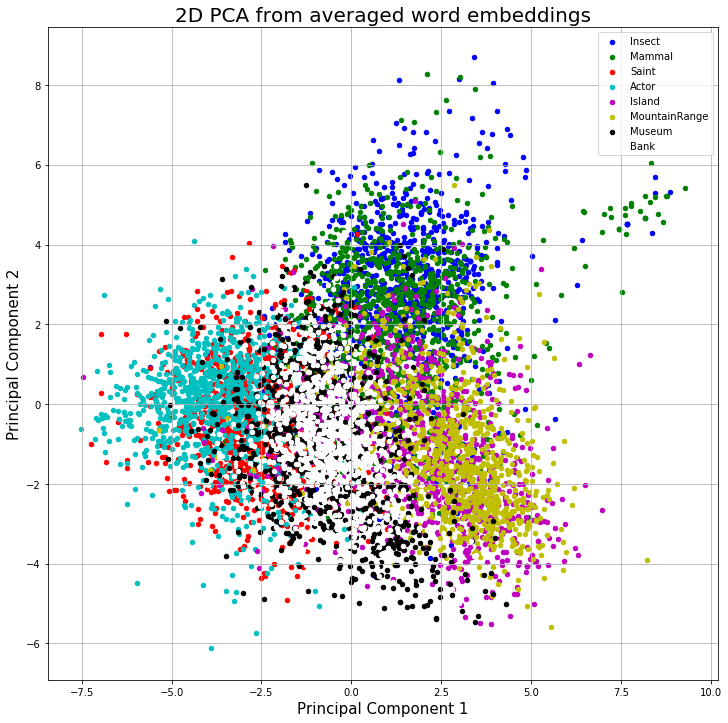

In [40]:
# Plot 
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2D PCA from averaged word embeddings', fontsize = 20)
targets = categories[:]
colors = ['b','g','r', 'c','m','y','k','w']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()


We can see the the two low-level categories are clustered together (e.g., mammal-insect, saint-actor, museum-bank), but the mid-level hierarchy is not clearly clustered. Let's see what happens with the CNN layers. To obtain them we will evaluate the validation set on the trained model (the weights have already been adjusted through learning). 

In [41]:
def get_output(model, layer_name, batch_size=512, Xtest=None, layer_2d_or_1d='2d'):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    layer_output = intermediate_layer_model.predict(Xtest, batch_size=batch_size, verbose=verbose)
    if layer_2d_or_1d=='2d':
        layer_output = np.reshape(layer_output,(len(Xtest), int(layer_output.shape[1])*int(layer_output.shape[3])))
    layer_output = pd.DataFrame(layer_output)
    return layer_output



In [42]:
conv_1 = get_output(cnn_model, 'conv_1', layer_2d_or_1d='2d', Xtest=X_validation_encoded)

dense_1 = get_output(cnn_model, 'dense_1', layer_2d_or_1d='1d', Xtest=X_validation_encoded)


8000/8000 [==============================] - 1s 63us/step


In [43]:
conv_1.shape # conv1 is 32*24, which if we vectorize it is 768 elements for each 8000 validation sentences

(8000, 768)

In [44]:
# Features
x = conv_1[:]
# Targets
y_train = [[n]*1000 for n in categories] 
y_train = [n for i in y_train for n in i]
# Standardizing the features
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame({'target': y_train})], axis = 1)
finalDf

,principal component 1,principal component 2,target
0,-5.696651,-2.703328,Insect
1,-7.604471,-1.840708,Insect
2,-6.899464,-3.889136,Insect
3,-3.897606,-6.370598,Insect
4,-3.124867,-4.229994,Insect
5,-7.344762,-3.590189,Insect
6,-5.901449,-4.917508,Insect
7,-2.831951,-1.356819,Insect
8,-7.195956,-4.607356,Insect
9,-7.618266,-2.575192,Insect


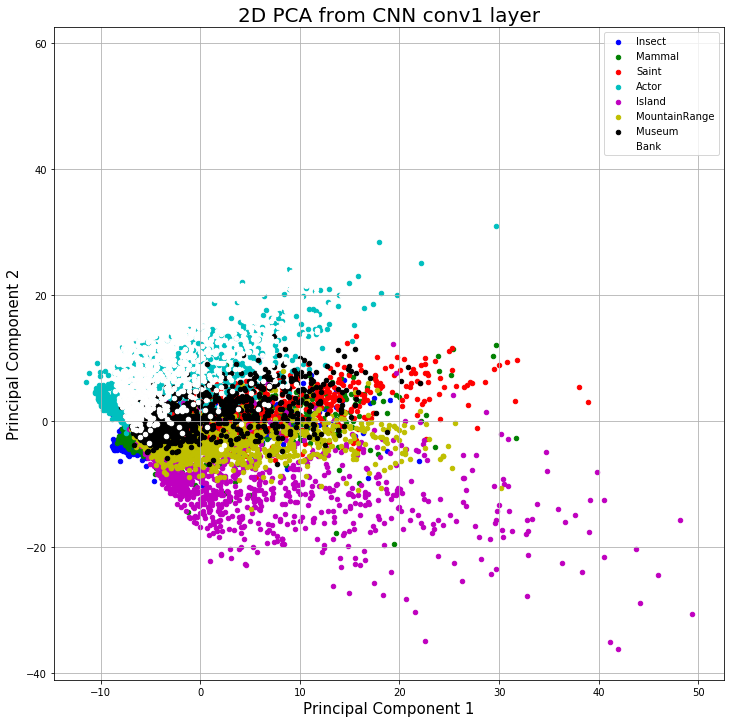

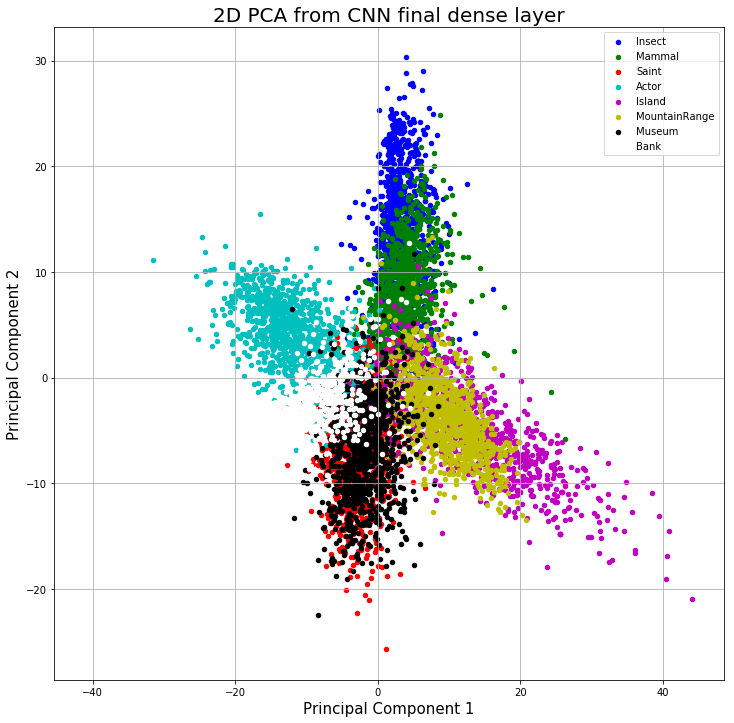

In [45]:

# Plot 

# conv1
# ================================================================
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2D PCA from CNN conv1 layer', fontsize = 20)
targets = categories[:]
colors = ['b','g','r', 'c','m','y','k','w']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()


# final dense layer
# ================================================================
# Features
x = dense_1[:]
# Targets
y_train = [[n]*1000 for n in categories] 
y_train = [n for i in y_train for n in i]
# Standardizing the features
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame({'target': y_train})], axis = 1)
finalDf


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2D PCA from CNN final dense layer', fontsize = 20)
targets = categories[:]
colors = ['b','g','r', 'c','m','y','k','w']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()

So we see that using the first layer (conv1) many of the samples overlap. Whereas, as the model progresses the last layers, it is able to find more variance between the samples. Here the 2D representation shows that each category is more seperable in the output layer. Furthermore, the pairs tend to cluster together, although there is no further hypercategorization (animate vs. inanimate). Therefore, we can visualize what these Deep Neural Networks are doing. 

There are other dimensionality reduction methods, in particular Linear Discriminant Analysis (LDA) is generally compared to PCA. For more information, see: https://sebastianraschka.com/Articles/2014_python_lda.html#lda-in-5-steps

For more advanced visualizations, check out: 
http://cs231n.github.io/understanding-cnn/

# That's it!

Thanks for reading. 

All code, data and figures: https://github.com/danielmlow/nlp_tutorial

Please give feedback or ask questions through github or at dlow@g.harvard.edu

# Acknowledgments
I would like to thank Prof. Mariano Méndez for letting me take his Linear Algebra and Multivariable Calculus class at the University of Groningen. 

# References

Goodfellow, I., Bengio, Y., Courville, A., & Bengio, Y. (2016). Deep learning (Vol. 1). Cambridge: MIT press.

Jurafsky, D., & Martin, J. H. (2014). Speech and language processing (Vol. 3). London: Pearson.

Smith, L. I. (2002). A tutorial on principal components analysis.




## Summary of more in-depth tutorials or chapters

Vector semantics:
* Jurafsky, D., & Martin, J. H. (2014). Speech and language processing (Vol. 3). London: Pearson. (chapter 15, available online)

Neural networks: 
* 3BLUE1BROWN series: https://www.youtube.com/watch?v=aircAruvnKk&index=1&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
* http://neuralnetworksanddeeplearning.com/ (short online book) 

Dimensionality reduction
* PCA:
    * The math of PCA: Smith, L. I. (2002). A tutorial on principal components analysis.
    * Eigenvectors and Eigenvalues: https://www.youtube.com/watch?v=PFDu9oVAE-g
    * PCA in python: https://plot.ly/ipython-notebooks/principal-component-analysis/
* LDA:  https://sebastianraschka.com/Articles/2014_python_lda.html#lda-in-5-steps




